In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import xgboost as xgb


from sklearn.metrics import roc_curve, auc
from collections import OrderedDict
from importlib import reload


from lib.main_func_p1 import path
from lib.main_func_p4 import model_clf
from lib.main_func_p4 import modelXGBoost_fit_scores
from lib.main_func_p4 import plot_ROC_curve

In [2]:
#####################################
# proteina (uniprot_ID)
uniprot_id = 'P00533'
path_file = path(uniprot_id)
# Parametros
seed = 142854
fp_name = 'morgan2_c'

In [3]:
all_type=False
save=True

list_excelfiles_to_process = []
for file in os.listdir(f'./top_scores/{uniprot_id}'):
    list_excelfiles_to_process.append(file)

ADME_df = pd.read_csv(f'{path_file}_02_ligands_smiles_ADME_lipinski.csv')

# Load top_scores excel file
excel_file = list_excelfiles_to_process[0]
top_scores = pd.read_excel(f'./top_scores/{uniprot_id}/{excel_file}')
resample_factor = int(str.split(excel_file,'_')[-1][2:][:-5])
score_metric = '_'.join(str.split(excel_file,'_')[5:-1])
resample_mode = 'under_sampling'
model_name = f'XGBoost_Clf'

# Load train and validation datasets
df_train = pd.read_pickle(f'{path_file}_dataset_train')
df_valid = pd.read_pickle(f'{path_file}_dataset_valid')
X_valid, y_valid = df_valid[fp_name].tolist(), df_valid['activity'].tolist()

eval_metric = ['error', 'auc']
params_dict = dict(eval(top_scores.params_dict[0]))
default_params_xgb = {'booster': 'gbtree', 'tree_method': 'gpu_hist',
                          'objective':'binary:logistic', 'grow_policy': 'depthwise',
                          'eval_metric': eval_metric, 'early_stopping_rounds':10}
params_dict.update(default_params_xgb)

# train and save the 'best' model
xgbc_tuned = xgb.XGBClassifier(**params_dict)
# Train model and evaluating scores (train / validation)
xgbc_tuned, scores_train, scores_valid = modelXGBoost_fit_scores(xgbc_tuned, fp_name, df_train, df_valid,
                                                              resample_factor=resample_factor,
                                                              resample_mode=resample_mode)
xgbc_tuned.save_model(f'./models/{uniprot_id}_model.ubj')
xgbc_tuned, df_results_model_tuned, results_ROC_fp = model_clf(xgbc_tuned, fp_name, uniprot_id, seed=seed,
                                                               save_log=True)

# Calcular probabilidades del conjunto de datos externo
pred_valid = xgbc_tuned.predict(X_valid)
df_valid['prediction'] = pred_valid

prediction_prob_valid = np.array(xgbc_tuned.predict_proba(X_valid)[:,1])
df_valid['prediction_prob'] = prediction_prob_valid

fpr_valid, tpr_valid, _ = roc_curve(y_valid, prediction_prob_valid)
auc_score_unseen = auc(fpr_valid, tpr_valid)
metrics_ROC_valid = (fpr_valid, tpr_valid, auc_score_unseen)
metrics_ROC = results_ROC_fp.copy()
metrics_ROC.extend([metrics_ROC_valid])
metrics_ROC_name = ['train(internal)', 'test(internal)', 'validation(external)']


Total=5129. 0.0(3553)/1.0(1576). ratio=2.25
Results XGBClassifier: 
-------------------------------------
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       533
         1.0       0.98      0.96      0.97       237

    accuracy                           0.98       770
   macro avg       0.98      0.98      0.98       770
weighted avg       0.98      0.98      0.98       770



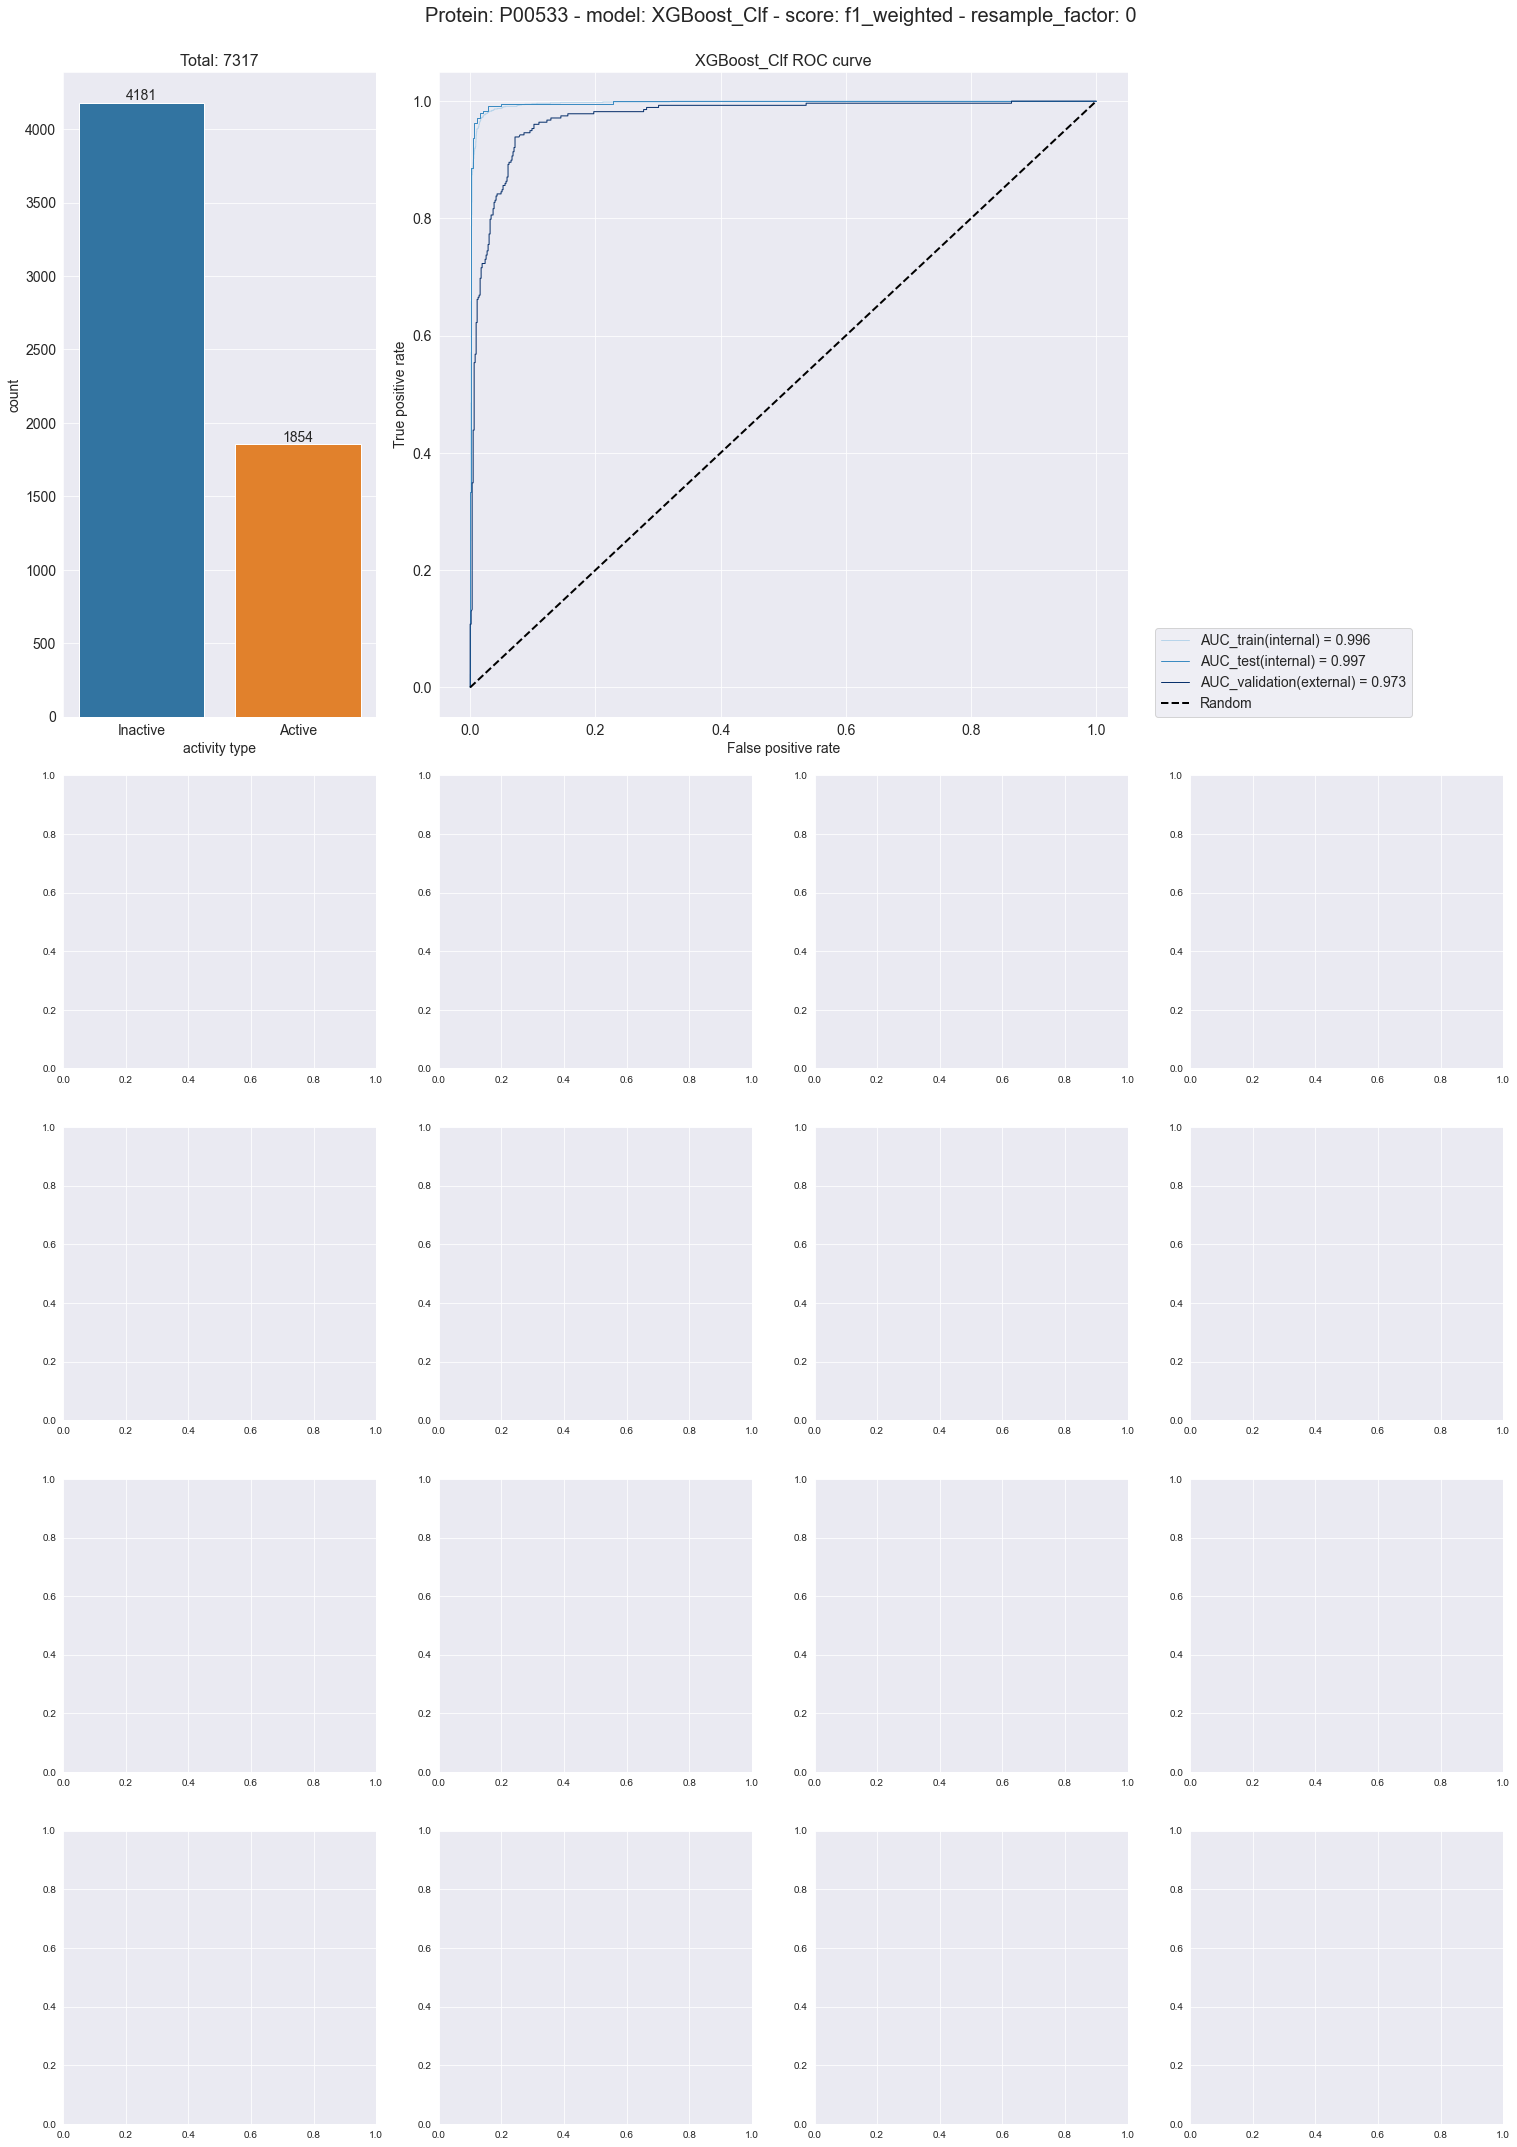

In [53]:
normal_size = 14
title_size = 16
figure, axes = plt.subplots(6, 4, figsize=(20, 30))
gs = GridSpec(6, 4, figure=figure)
figure.suptitle(f'Protein: {uniprot_id} - model: {model_name} - score: {score_metric} - resample_factor: {resample_factor} ', size=20)
axes[0,0].remove()
axes[0,1].remove()
axes[0,2].remove()
axes[0,3].remove()
axes[1,0].remove()
axes[1,1].remove()
axes[1,2].remove()
axes[1,3].remove()
axes[0,0] = figure.add_subplot(gs[:2, 0])
axes[0,1] = figure.add_subplot(gs[:2, 1:3])
# 1. Plot  count active /inactive
if all_type:
        sns.countplot(ax=axes[0,0], x='activity_type', data=ADME_df, order=['Inactive', 'Intermediate', 'Active'])
else:
    sns.countplot(ax=axes[0,0], x='activity_type', data=ADME_df, order=['Inactive', 'Active'])
axes[0,0].set_title(f'Total: {len(ADME_df)}',fontsize=title_size)
axes[0,0].bar_label(container=axes[0,0].containers[0], fmt='%g', fontsize=normal_size)
axes[0,0].set_xlabel('activity type', size=normal_size)
axes[0,0].set_ylabel('count', size=normal_size)
axes[0,0].tick_params(labelsize=normal_size)
# -------------------------------

# 2. Plot  ROC curve
cmap = cm.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0.3, 1.0, len(metrics_ROC))]
for i, metrics in enumerate(metrics_ROC):
    fpr, tpr, roc_auc = metrics[0], metrics[1], metrics[2]
    name = metrics_ROC_name[i]
    axes[0,1].plot(fpr, tpr, lw=1, color=colors[i], label='AUC_{} = {:.3f}'.format(name, roc_auc))

axes[0,1].plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
axes[0,1].set_xlabel('False positive rate', size=normal_size)
axes[0,1].set_ylabel('True positive rate', size=normal_size)
axes[0,1].set_title(model_name + ' ROC curve', size=title_size)
axes[0,1].tick_params(labelsize=normal_size)
axes[0,1].legend(fontsize=normal_size, loc=(1.04, 0))
# set the spacing between subplots
plt.subplots_adjust(left=0, bottom=0, right=1, top=0.95, wspace=0.2, hspace=0.2)
plt.show()
plt.close()

In [18]:
import lib.main_func_p4
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_calibration_curve